In [112]:
import joblib
import itertools
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Run ML Experiment

## Prepare Data

In [113]:
# Load Data 

PROJECT_DIR = Path(os.getcwd()).parent.absolute()
churn_filepath = PROJECT_DIR/'data'/'Churn_Modelling.csv'

In [114]:
df = pd.read_csv(churn_filepath)
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [115]:
df.shape

(10000, 14)

In [116]:
# Are there missing values?
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [117]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [118]:
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'


X, y = df[cat_cols + num_cols], df[targ_col]

In [119]:
y.mean()

0.2037

In [120]:
# Data Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Train a model

In [121]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

# Select algorithm
clf = RandomForestClassifier(random_state=random_state,  **train_params)
# clf = LGBMClassifier(random_state=random_state, **train_params)
# clf = XGBClassifier(random_state=random_state, **train_params)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler())
        ]
    )
categorical_transformer = OrdinalEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Geography', 'Gender'])])),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [122]:
# Save model 

joblib.dump(model, PROJECT_DIR/'models/model.joblib')

['/Users/mikhailrozhkov/dev/cse_public/example-easy-experiments-bank-churn/models/model.joblib']

## Evaluate

In [123]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, f1_score,
                             roc_auc_score)
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

In [124]:
# Get predictions 

y_prob = model.predict_proba(X_test)
y_pred = (y_prob[:, 1] >= 0.5).astype(int)

In [125]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [126]:
# Calculate Metrics

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])

print(f1)
print(roc_auc)

0.5688073394495413
0.8607069275362611


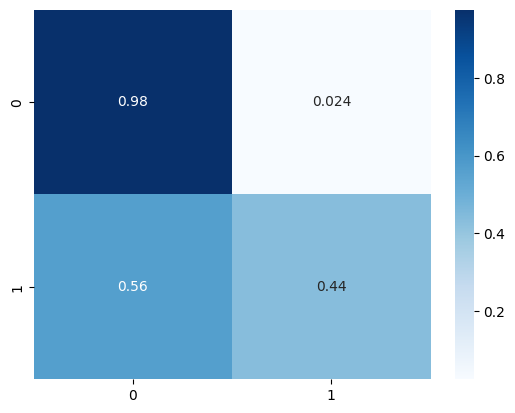

In [127]:
# Plot Confusion Matrix 

cm = confusion_matrix(y_test, y_pred, normalize='true') 
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues) 

# Save image file
plt.savefig(PROJECT_DIR/'results/cm.png')

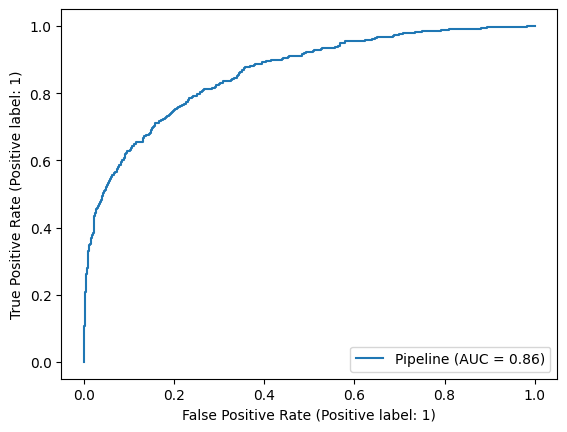

In [128]:
# ROC-AUC Curve

# fig, ax = plt.subplots()
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)

## Feature Importance

In [129]:
# Prepare Predictions Table

df_test = X_test.copy(deep=True)
df_test['true'] = y_test
df_test['pred'] = y_pred
df_test['prob'] = y_prob[:, 1]

# Save Predictions
df_test.to_csv(PROJECT_DIR/'results/predictions.csv', index=True)

df_test.head()

Geography  Gender  CreditScore  Age  Tenure    Balance  NumOfProducts  \
6252   Germany    Male          596   32       3   96709.07              2   
4684    France    Male          623   43       1       0.00              2   
1731     Spain  Female          601   44       4       0.00              2   
4742   Germany    Male          506   59       8  119152.10              2   
4521     Spain  Female          560   27       7  124995.98              1   

      HasCrCard  IsActiveMember  EstimatedSalary  true  pred      prob  
6252          0               0         41788.37     0     0  0.033832  
4684          1               1        146379.30     0     0  0.041014  
1731          1               0         58561.31     0     0  0.116535  
4742          1               1        170679.74     0     0  0.154570  
4521          1               1        114669.79     0     0  0.123252

In [130]:
### 2 - Calculcate and save Feature Importance
# Calculate Feature Importance for Train

perm = permutation_importance(
    model, X_train, y_train, n_repeats=3, random_state=0, n_jobs=2)


sorted_importances_idx = perm.importances_mean.argsort()
feat_imp_train = pd.DataFrame(
    perm.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

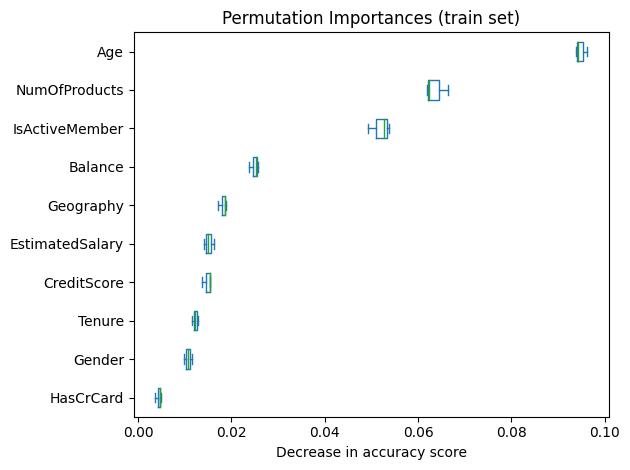

In [131]:
ax = feat_imp_train.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [132]:
# Feature Importance 

# Prepare Feature Importance Table

fimp_df = (feat_imp_train
 .agg(['mean', 'std'], axis=0)
 .T.sort_values(by='mean', ascending=False)
)

# Save Feature Importance Table
fimp_df.to_csv(PROJECT_DIR/'results/feat_imp_train.csv', index=True)

fimp_df.head()

mean       std
Age             0.094756  0.001336
NumOfProducts   0.063600  0.002433
IsActiveMember  0.051956  0.002318
Balance         0.024933  0.001058
Geography       0.018222  0.000888

# DVCLive: Log results of an expeiriment

## 1 - Log metrics, plots, models and datatsets

Notes:
- `dir` Location of the directory to store outputs (default value is 'dvclive')
- If `dvcyaml=True` (default) and you include any of the fields in `[type, name, desc, labels, meta]`, it will add all the artifact's metadata to the corresponding dvc.yaml.
- Passing `type="model"` will mark it as a model for DVC and will make it appear in Studio model registry.
- Docs: https://dvc.org/doc/dvclive/live/log_artifact 

In [133]:
from dvclive import Live

with Live(dir=PROJECT_DIR/'results/dvclive',
          dvcyaml=True,
         ) as live:

    # Log metrics
    live.log_metric('f1', f1)
    live.log_metric('roc_auc', roc_auc)

    # Log an existing image
    live.log_image('cm.png', PROJECT_DIR/'results/cm.png')

    # Log Matplotlib Figure as an image
    svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
    live.log_image("roc.png", svc_disp.figure_)

    # Log Model
    live.log_artifact(
        path = PROJECT_DIR/'models/model.joblib',
        type = 'model', 
        cache  = False,  # Version with Git and not cache in DVC storage
        labels = list(fimp_df.index),
        meta = fimp_df.to_dict(orient='index')
    )

    # Log data artifact 
    live.log_artifact(
        path = PROJECT_DIR/'results/feat_imp_train.csv',
        type = 'dataset',
        name = 'feature-importance-train', # custom name of an artifact (use dashes '-' instead of '_' underscores)
        desc = 'Permutation based Feature Importance for Train dataset',
        labels = ['train'],
        meta = {'n_repeats': 3},
        copy  = False,
        cache  = True, # Version with DVC - store in DVC cache/storage
    )

	dvc_plots/index.html, models/model.joblib, results/cm.png, results/predictions.csv, results/gridsearch/metrics.json, results/gridsearch/plots/metrics/f1.tsv, results/gridsearch/plots/metrics/roc_auc.tsv, results/feature_importance/metrics.json, results/feature_importance/plots/custom/feature_importance.json, data/Churn_Modelling.csv


## 2 - Commit results with Git and DVC

- Follow README instructions to set up DVC `local` storage to follow the example
- Documentation on [DVC Remote Storage](https://dvc.org/doc/user-guide/data-management/remote-storage#remote-storage)

In [134]:
# !git add ../results/dvclive      # Commit DVC metadata and 'dvclive' dir to Git
# !git push                        # Push changes to Git remote

In [135]:
# !dvc push -r local               # Push DVC tracking artifacts to DVC remote storage 

# DVCLive: Monitor your experimetns in Live mode with DVCLive and Studio

## 1 - Connect Studio DVCLive

Note: 
- Create Studio access token and set up DVC: https://dvc.org/doc/studio/user-guide/projects-and-experiments/live-metrics-and-plots#set-up-an-access-token

- 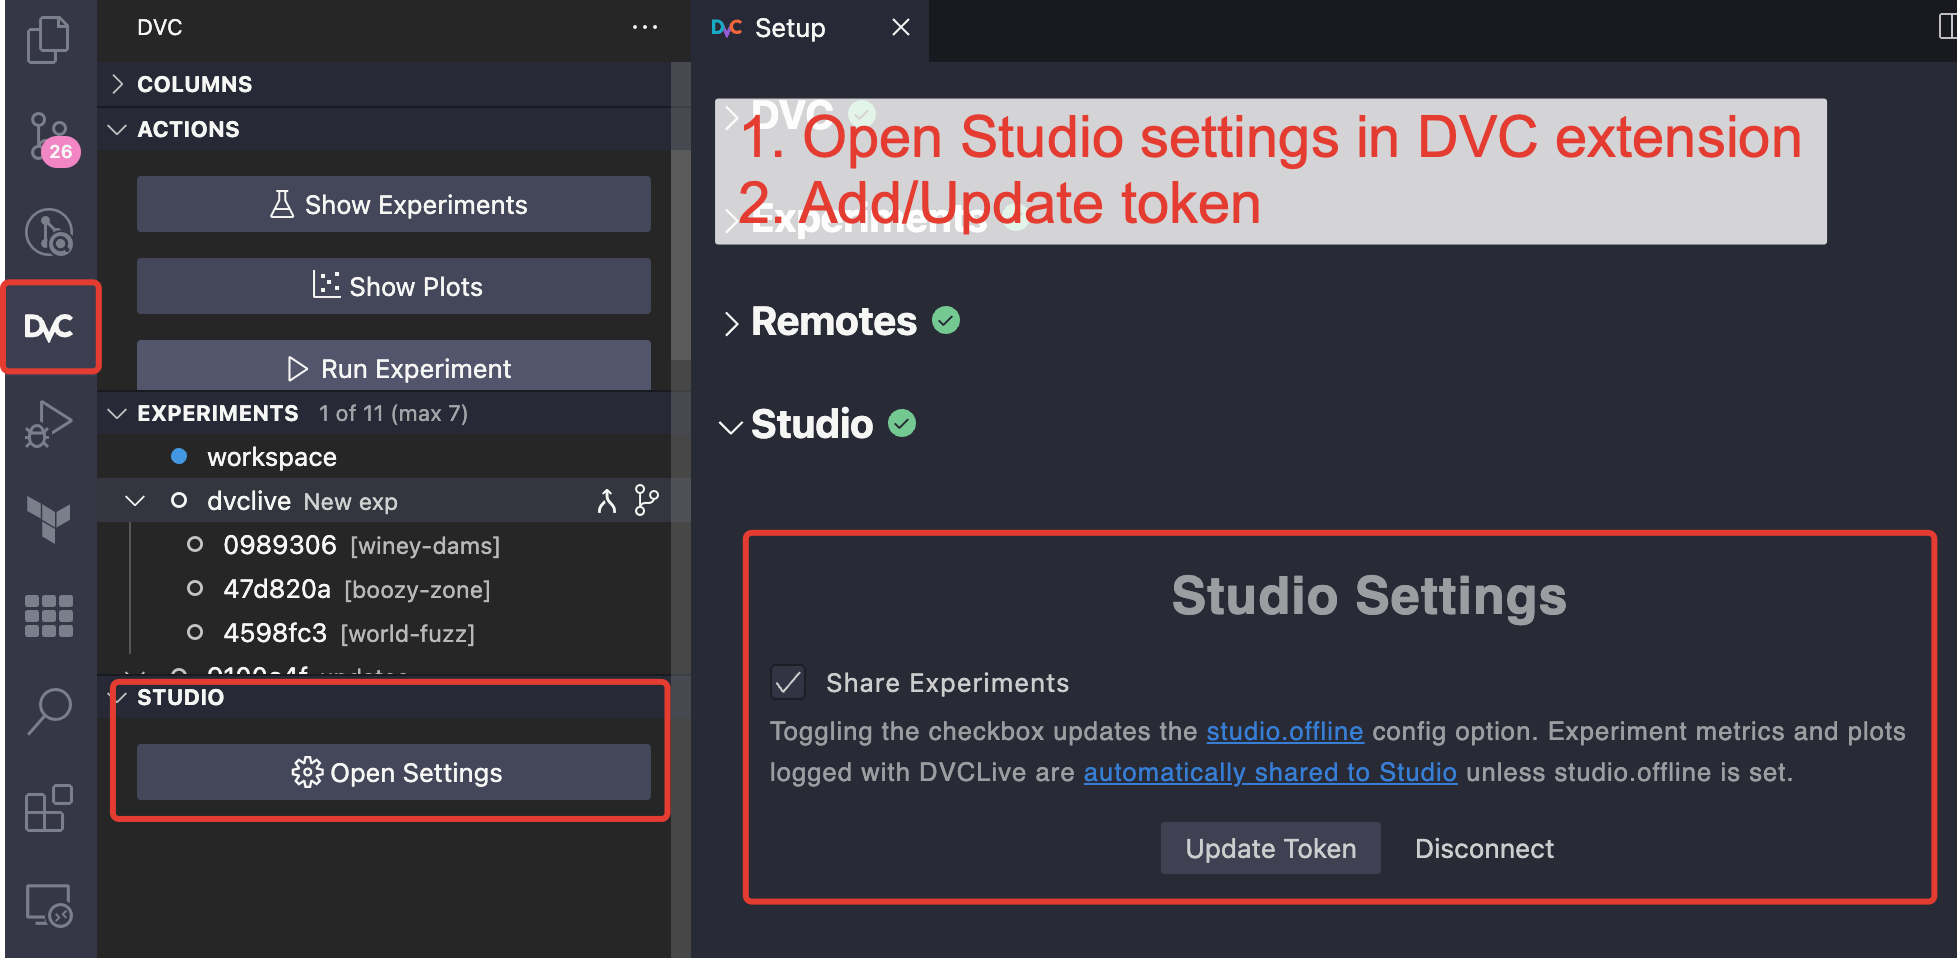

In [136]:
# ! dvc config --global studio.token ***

## 2 - Run ML training with several steps/epochs

# DVC Report

metrics.json

|      f1 |   roc_auc |   step |
|---------|-----------|--------|
| 0.57377 |  0.847736 |     15 |

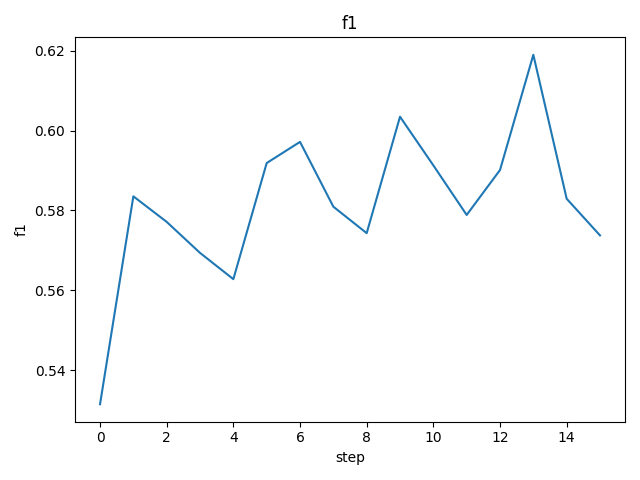

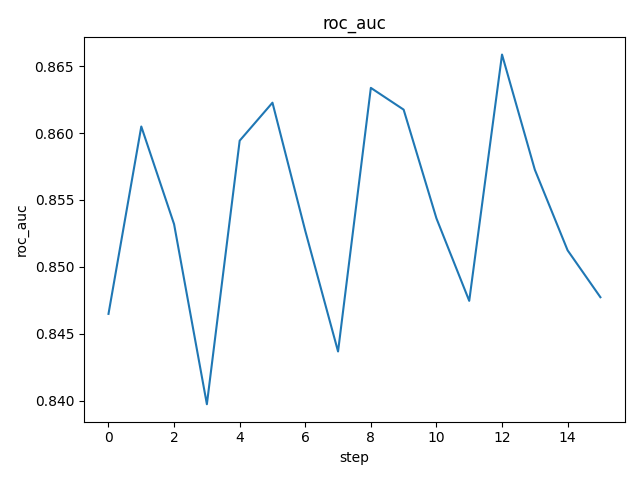


	dvc_plots/index.html, models/model.joblib, results/cm.png, results/predictions.csv, results/feat_imp_train.csv.dvc, results/feature_importance/metrics.json, results/feature_importance/plots/custom/feature_importance.json, results/dvclive/metrics.json, notebook/dvc.yaml, data/Churn_Modelling.csv


In [137]:
# Run multiple experiments for parameters combination 
params = {
    'n_estimators': [10, 20, 30, 50],     
    'max_depth': [3, 6, 12, 24]
}

with Live(dir=PROJECT_DIR/'results/gridsearch',
          save_dvc_exp=True,  # DVCLive will create a new DVC experiment 
          dvcyaml="../dvc.yaml",
          report='notebook',  # Display a report in the Notebook
         ) as live:
    
    # Iterate over parameters, folds or epocs
    for _params in list(itertools.product(params['n_estimators'], params['max_depth'])):

        # Get params to train
        train_params = {
            'n_estimators': _params[0], 
            'max_depth': _params[1]
        }

        # Train a model
        xgb = XGBClassifier(random_state=random_state, **train_params)
        model_xgb = Pipeline(steps=[("preprocessor", preprocessor), ("clf", xgb)])
        model_xgb.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model_xgb.predict(X_test)
        y_prob = model_xgb.predict_proba(X_test)

        # Calculate metrics 
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])

        # Log metrics
        live.log_metric('f1', f1)
        live.log_metric('roc_auc', roc_auc)

        # Signal that the current iteration has ended and increases step value by 1 (one).
        live.next_step()



## 3 - Commit results with Git and DVC

- Follow README instructions to set up DVC `local` storage to follow the example
- Documentation on [DVC Remote Storage](https://dvc.org/doc/user-guide/data-management/remote-storage#remote-storage)

In [138]:
# !git add ../results/dvclive      # Commit DVC metadata and 'dvclive' dir to Git
# !git push                        # Push changes to Git remote

In [139]:
# !dvc push -r local               # Push DVC tracking artifacts to DVC remote storage 

# DVCLive: Feature Importance

In [140]:
fimp_df.head()

mean       std
Age             0.094756  0.001336
NumOfProducts   0.063600  0.002433
IsActiveMember  0.051956  0.002318
Balance         0.024933  0.001058
Geography       0.018222  0.000888

In [141]:
datapoints = (
    fimp_df.reset_index().rename(columns={'index': 'column', 'mean': 'coef'})
    .loc[:, ['column', 'coef']]
    .round(3)
    .to_dict('records')
)
datapoints

[{'column': 'Age', 'coef': 0.095},
 {'column': 'NumOfProducts', 'coef': 0.064},
 {'column': 'IsActiveMember', 'coef': 0.052},
 {'column': 'Balance', 'coef': 0.025},
 {'column': 'Geography', 'coef': 0.018},
 {'column': 'EstimatedSalary', 'coef': 0.015},
 {'column': 'CreditScore', 'coef': 0.015},
 {'column': 'Tenure', 'coef': 0.012},
 {'column': 'Gender', 'coef': 0.011},
 {'column': 'HasCrCard', 'coef': 0.004}]

In [142]:
with Live(dir=PROJECT_DIR/'results/feature_importance',
          save_dvc_exp=False,  # DVCLive will create a new DVC experiment 
          dvcyaml="../dvc.yaml",
) as live:
    live.log_plot(
        "feature_importance",
        datapoints,
        x="coef",
        y="column",
        template="bar_horizontal_sorted",
        title="Feature Importance",
        y_label="Feature Name",
        x_label="Feature Importance"
    )

In [143]:
# from dvclive import Live

# datapoints = [
#     {"name": "petal_width", "importance": 0.4},
#     {"name": "petal_length", "importance": 0.33},
#     {"name": "sepal_width", "importance": 0.24},
#     {"name": "sepal_length", "importance": 0.03}
# ]

# with Live() as live:
#     live.log_plot(
#         "iris_feature_importance",
#         datapoints,
#         y="importance",
#         x="name",
#         template="bar_horizontal",
#         title="Iris Dataset: Feature Importance",
#         y_label="Feature Name",
#         x_label="Feature Importance"
#     )

In [144]:
# pd.DataFrame(datapoints)

In [145]:
# pd.DataFrame(datapoints).set_index('name').to_dict('dict')['importance']